In [1]:
import os
import time
import pickle
import cv2 as cv
import numpy as np 
import pyttsx3 as tts
from mtcnn import MTCNN
import tensorflow as tf 
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
from keras_facenet import FaceNet
from serial import Serial, SerialException
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



2024-10-29 12:22:06.375778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 12:22:07.044944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 12:22:07.190924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 12:22:08.436859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 12:22:13.658433: W tensorflow/compiler/tf2

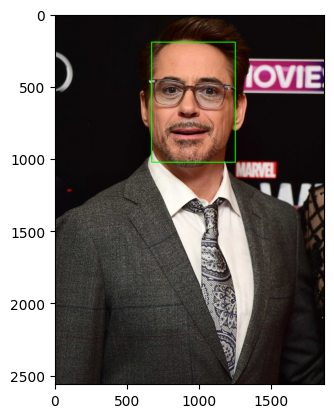

In [3]:

# ------------- test the MTCNN Model --------------

detector = MTCNN()
img = "train_data/robert_downey/3.jpg"
img = cv.imread(img)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(img)[0]['box']
cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),5)
plt.imshow(img)


In [11]:
class Feature_Extraction:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.detector = MTCNN()
        self.X = []
        self.Y = []

    def extract_face(self, file_name):
        img = cv.imread(file_name)
        if img is None:
            print(f"Failed to load image {file_name}. It may be corrupted or not exist.")
            return None
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        faces = self.detector.detect_faces(img)

        if len(faces) == 0:
            print(f"No faces found in {file_name}.")
            return None

        x, y, width, height = faces[0]['box']
        x, y = abs(x), abs(y)
        face = img[y:y + height, x:x + width]
        face_arr = cv.resize(face, self.target_size)
        return face_arr

    def load_faces(self, dir):
        FACE = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_face(path)
                if single_face is not None:
                    FACE.append(single_face)
            except Exception as e:
                print("Exception while load_face: {}".format(e))
        return FACE

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            print(path)
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            self.X.extend(FACES)
            self.Y.extend(labels)
        return np.asarray(self.X), np.asarray(self.Y)
    

    def plot_image(self):
        for num,image in enumerate(self.X):
            ncols = 6
            nrows = (int) (len(self.Y)//ncols)
            if num>= ncols*nrows:
                break
            plt.subplot(nrows,ncols,num+1)
            plt.axis("off")
            plt.imshow(image)


face_loading = Feature_Extraction("train_data")
X,Y = face_loading.load_classes()


train_data/taylor_swift
train_data/robert_downey
No faces found in train_data/robert_downey/10.jfif.
train_data/yasin
No faces found in train_data/yasin/b56009f6-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b1afab04-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/ac641dba-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b4a48190-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/ac626f92-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/adf9cea4-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b26a0c9c-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b9f6f24a-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/aeabc906-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/aaf5e2ec-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b3331056-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/

In [12]:
len(Y)

79

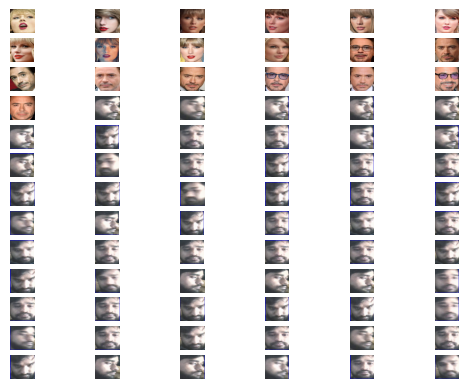

In [13]:
face_loading.plot_image()

In [14]:
embedder = FaceNet()

def get_embedding(img):
    face_img = img.astype(np.float32) # 3d (160,160,3)
    face_img = np.expand_dims(face_img,axis=0) # 4D (None,160,160,3)
    yhat = embedder.embeddings(face_img)
    return yhat

EMBEDDING_X  = []
for img in X:
    EMBEDDING_X.append(get_embedding(img))
EMBEDDING_X = np.asarray(EMBEDDING_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━

In [15]:
np.savez_compressed("face_net_embedding",EMBEDDING_X,Y)

<br>

# `preparation for ml SVM:`

<br>

In [16]:
Y # we need to convert this into number: we will use label encoding: cause here we use uqinue name of the folder: 

array(['taylor_swift', 'taylor_swift', 'taylor_swift', 'taylor_swift',
       'taylor_swift', 'taylor_swift', 'taylor_swift', 'taylor_swift',
       'taylor_swift', 'taylor_swift', 'robert_downey', 'robert_downey',
       'robert_downey', 'robert_downey', 'robert_downey', 'robert_downey',
       'robert_downey', 'robert_downey', 'robert_downey', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin'], dtype='<U13')

In [17]:
labelEncoder = LabelEncoder()
Y = labelEncoder.fit_transform(Y)
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [18]:
X_train,X_test,y_train,y_test = train_test_split(EMBEDDING_X,Y,test_size=0.2,random_state=17,shuffle=True)
print("X_train shpae : {}".format(X_train.shape))
print("y_train shpae : {}".format(y_train.shape))
print("X_test shpae : {}".format(X_test.shape))
print("y_test shpae : {}".format(y_test.shape))

X_train shpae : (63, 1, 512)
y_train shpae : (63,)
X_test shpae : (16, 1, 512)
y_test shpae : (16,)


In [19]:
X_train = X_train.reshape(63,512)
X_test = X_test.reshape(16,512)

In [20]:
model = SVC(kernel="linear",probability=True)
model.fit(X_train,y_train)

SVC(kernel='linear', probability=True)

In [21]:
y_pred = model.predict(X_test)
accuracy_score(y_pred=y_pred,y_true=y_test)*100

100.0

<br>

# `test a person:`

<br>

In [22]:
detector = MTCNN()
embedder = FaceNet()
test_img = cv.imread("train_data/robert_downey/8.jpg")
test_img = cv.cvtColor(test_img,cv.COLOR_BGR2RGB)
x,y,width,height = detector.detect_faces(test_img)[0]['box']
test_img = test_img[y:y+height ,x:x+width]
test_img = cv.resize(test_img,(160,160))
embd_vec = embedder.embeddings([test_img])
y_pred = model.predict(embd_vec)
labelEncoder.inverse_transform(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array(['robert_downey'], dtype='<U13')

In [23]:
test_img = cv.imread("train_data/taylor_swift/6.jpg")
test_img = cv.cvtColor(test_img,cv.COLOR_BGR2RGB)
x,y,width,height = detector.detect_faces(test_img)[0]['box']
test_img = test_img[y:y+height ,x:x+width]
test_img = cv.resize(test_img,(160,160))
embd_vec = embedder.embeddings([test_img])
y_pred = model.predict(embd_vec)
labelEncoder.inverse_transform(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


array(['taylor_swift'], dtype='<U13')

In [24]:

# save the svm model with pickle

with open("svm_face_verification_model.pkl",'wb') as f:
    pickle.dump(model,f)


<br>
<br>

---

# `Perform real Time faceRecognition: `

---

<br>
<br>

# connect with arudino: 

In [29]:
faces_embeddings = np.load("face_net_embedding.npz")
faces_embeddings['arr_1']

array(['taylor_swift', 'taylor_swift', 'taylor_swift', 'taylor_swift',
       'taylor_swift', 'taylor_swift', 'taylor_swift', 'taylor_swift',
       'taylor_swift', 'taylor_swift', 'robert_downey', 'robert_downey',
       'robert_downey', 'robert_downey', 'robert_downey', 'robert_downey',
       'robert_downey', 'robert_downey', 'robert_downey', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin'], dtype='<U13')

In [2]:

# --------------- test the audio ---------

engine = tts.init()
rate = engine.getProperty('rate')
print(rate)
engine.setProperty('rate',150)
engine.say("text to speech is connected")
engine.runAndWait()

200


In [3]:

# Initialize face recognition components
facenet = FaceNet()
faces_embeddings = np.load("face_net_embedding.npz")
labelEncoder_new = LabelEncoder()   
labelEncoder_new.fit(faces_embeddings['arr_1'])
haarcascade = cv.CascadeClassifier("haarcascade_frontalface_default.xml")
model = pickle.load(open("svm_face_verification_model.pkl", 'rb'))

UNKNOWN_THRESHOLD = 0.92
cap = cv.VideoCapture(0)


# --------------------------- arduino connection start -----------------------------------------
# Set up serial communication
arduino_port = '/dev/ttyACM0'
arduino = None

try:
    arduino = Serial(arduino_port, 9600)
    time.sleep(2)  # Give time for the connection to establish
    print("Arduino connected successfully")
except SerialException as e:
    print(f"Error connecting to Arduino: {e}")
    exit


# Variables for timing
last_detection_time = 0
detection_duration = 20

# Time before door closes to announce closing
door_closing_warning = 3


while cap.isOpened():
    current_time = time.time()
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    frame = cv.flip(frame, 1)
    rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    gray_img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    faces = haarcascade.detectMultiScale(gray_img, 1.3, 5)

    for x, y, w, h in faces:
            img = rgb_img[y:y+h, x:x+w]
            img = cv.resize(img, (160, 160))
            img = np.expand_dims(img, axis=0)
            ypred = facenet.embeddings(img)

            proba = model.predict_proba(ypred)
            max_proba_index = np.argmax(proba)
            confidence = proba[0][max_proba_index]
            print(confidence)
            face_name = model.classes_[max_proba_index]

        # ------------ check the confidence score ----------------
            if confidence > UNKNOWN_THRESHOLD:
                final_name = labelEncoder_new.inverse_transform([face_name])[0]
                cv.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
                cv.putText(frame, str(final_name), (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv.LINE_AA)
                    
                if current_time - last_detection_time < detection_duration:
                    procecssing_name = f"processing for {final_name}"
                    #time_in = time_in - 1
                    cv.putText(frame, procecssing_name, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv.LINE_AA)
                
                # Skip sending command to Arduino during processing period
                if (current_time - last_detection_time) >= detection_duration:
                    arduino.write(f"OPEN {final_name}\n".encode())
                    print(f"Command sent to Arduino: OPEN {final_name}")
                    say_name = str(f"Door is opening for {final_name} about 10 second")
                    engine.say(say_name)
                    engine.setProperty('rate',125)
                    engine.runAndWait()
                    last_detection_time = current_time 
                    #time_in = detection_duration 
                
              
            else:
                cv.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
                cv.putText(frame, "Unknown Person", (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv.LINE_AA)
                final_name = "Unknown Person"
                arduino.write(f"Wrong \n".encode())
                if current_time - last_detection_time >= detection_duration:
                    last_detection_time = current_time 

    cv.imshow("Face Recognition:", frame)
    if cv.waitKey(1) & 0xff == ord('q'):
        break

cap.release()
cv.destroyAllWindows()




I0000 00:00:1730204566.529596    1782 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 12:22:46.809604: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Arduino connected successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
0.6861597558603327


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/run/media/hadi/5f8d8692-3a2d-40bb-80e6-ad56a68d2e5c/3rd_Semester/3rd_sem_arduino_project/venv/lib/python3.12/site-packages/cv2/qt/plugins"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
0.6945755329708013
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
0.6635575991048037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
0.5890946361984807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
0.6590275508702547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
0.6580729127796163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
0.6857766105745167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
0.6786224584258574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
0.6892142055240903
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
0.6966448006275463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
0.6810230269817757
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
0.7026962707010186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
0.7137194917647498
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
0.6699972858408493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
0.5421311486835919
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
0.5863377718541674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
0.7004194623713141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
0.7121746125065236
1/1 ━━━━━━━━━━━━━━━━━━━